# Исследование объявлений о продаже квартир

**Данные** - <em>архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.</em><br>
**Цель** - <em>установить параметры для построения автоматизированной системы, которая отследит аномалии и мошенническую деятельность.</em><br>
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Описание данных**
-	airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
-	balcony — число балконов
-	ceiling_height — высота потолков (м)
-	cityCenters_nearest — расстояние до центра города (м)
-	days_exposition — сколько дней было размещено объявление (от публикации до снятия)
-	first_day_exposition — дата публикации
-	floor — этаж
-	floors_total — всего этажей в доме
-	is_apartment — апартаменты (булев тип)
-	kitchen_area — площадь кухни в квадратных метрах (м²)
-	last_price — цена на момент снятия с публикации
-	living_area — жилая площадь в квадратных метрах(м²)
-	locality_name — название населённого пункта
-	open_plan — свободная планировка (булев тип)
-	parks_around3000 — число парков в радиусе 3 км
-	parks_nearest — расстояние до ближайшего парка (м)
-	ponds_around3000 — число водоёмов в радиусе 3 км
-	ponds_nearest — расстояние до ближайшего водоёма (м)
-	rooms — число комнат
-	studio — квартира-студия (булев тип)
-	total_area — площадь квартиры в квадратных метрах (м²)
-	total_images — число фотографий квартиры в объявлении<br></em>

**Пояснение:** <em>апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.</em>


## Оглавление
1. [Загрузка данных и изучение общей информации по проекту](#download-data)
2. [Предобработка данных](#data-preprocessing)
    - [Обработка пустых значений](#processing-empty-values)
    - [Замена типа данных](#data-type-change)
3. [Расчет данных  и добавление их таблицу](#data-counting)
    - [Расчет стоимости 1 квадратного метра](#calculating-the-price-per-square-meter)
    - [Определение дня недели, месяца и года публикации объявления](#determine-the-day-of-the-week-month-and-year)
    - [Категорирование квартиры по этажности](#categorizing-the-apartment-by-floor)
    - [Определение соотношения жилой и общей площади, отношения площади кухни к общей](#determination-of-the-ratio)
4. [Анализ данных](#data-analysis)
    - [Исследование типичных параметров продаваемых квартир: площадь, цена, число комнат и т.д.](#research-parameters)
    - [Исследование времени продажи квартиры](#researching-days-exposition)
    - [Обработка необычных значений параметров](#processing-rare&knockout-values)
    - [Исследование факторов, влияющих на стоимость квартиры](#research-factors-affecting-cost)
    - [Исследование 10 населённых пунктов с наибольшим числом объявлений](#research-exposition-location)
    - [Исследование характеристик типичных квартир в центре и вне центра](#research-centre-or-no-centre)
    - [Исследование характерных параметров для апартаментов, студий и квартир свободной планировки](#research-nontypical-flat)
5. [Выводы](#conclusions)

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Хорошее меню.
</div>

## <a id='download-data'><span style="color:black">1. Загрузка данных и изучение общей информации по проекту</span></a>

Предварительное изучение данных с помощью текствого редактора позволило определить столбец 'Unnamed: 0' в качестве индекса, что позволяет оптимизировать размер используемой
память.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# код для отображения 30 столбцов
pd.options.display.max_columns = 30

In [2]:
data = pd.read_csv('datasets/real_estate_data.csv', index_col='Unnamed: 0')
display(data)
display(data.describe())
display(data.info(memory_usage='deep'))
display(data[(data['is_apartment'].notnull())]['is_apartment'].value_counts())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,False,False,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

False    2725
True       50
Name: is_apartment, dtype: int64

Предоставленная база данных состоит из 23699 строк и 22 столбцов. Данные имеют следующий тип данных bool, float, int, object. Первично изучение данных позволяет увидеть следующие недостатки и аномалий:
- столбец total_images - избыточен, т.е. в анализе данных применятся не будет. Данный столбец нужно удалить с целью уменьшения размера используемой памяти.
- столбец last_price - пропущенных значений не имеет, для удобства представления тип данных можно изменить на int.
- total_area - пропущенных значений не имеет, тип данных float.
- ceiling_height - имеет пропущенные значения, которые необходимо заполнить. Скорее всего данные не были указанны собственниками при подаче объявления, т.к. посчитали такую информацию не важной. Обычно в таком случае высота потолков имеет стандартный размер  (2.5-2.7 м). Кроме того, обращает на себя внимание, что минимальное значение в данном стролбце равно 1 и максимальное значение 100, что не возможно и такие данные должным быть заменены другими.
- floors_total - имеет незначительное количество пустых значений, которые могут быть удалены или оставлены пустыми, тип данных нужно изменить на int.
- living_area - имеет около 10% пустых значений, данная категория имеет существенное значение при определении стоимости квартиры. Нужно рассмотреть возможность заполнения пропусков.
- is_apartment - имеет тип данных object, но должен быть изменен на bool. Большое количество пустых значений, при этом значений True только 50. Скорее всего такие данные не были предоставлены собственниками как не существенные. Такая информация указывается только если помещение является аппартаментами, поэтому все пропущенные значения должны быть заменены на False.
- kitchen_area - имеет около 10% пустых значений, данная категория может иметь существенное значение при определении стоимости квартиры. Нужно рассмотреть возможность заполнения пропусков.
- balcony - имеет пропуски, скорее всего человек не указал число балконов, так как их нет. Такие пропуски правильно заменить на 0. Тип данных необходимо заменить на int. Максимальное значение в данной категории равно 5, что само по себе вызывает вопрос в реальности такой информации.
- locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - имеют некоторое количество пропусков.

Перед тем как приступить к обработке пустых значений удалим столбец total_images из базы данных.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Вопрос на подумать. На какую квартиру пользователь обратит внимание, на квартиру у которой нет фотографий или у которой есть фотографии? 
</div>

In [3]:
data = data.drop('total_images', axis=1)
display(data.head())

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Вывод:** Изучение данных позволило выявить ряд недостатков и аномалий, которые необходимо устранить до перехода к анализу.

## <a id='data-preprocessing'><span style="color:black">2. Предобработка данных</span></a>

### <a id='processing-empty-values'><span style="color:black">Обработка пустых значений</span></a>

Произведем замену пустых и аномальных значений в столбце ceiling_height. Согласно строительным нормам минимальная высота потолка не может быть меньше 2.4 метра. Максимальная высота потолка строительными нормами не установлена. Встречаются постройки с высотой выше 4 метров (особенно это касается домов дореволюционной постройки). Заменим пустые значения и значения меньше 2,4 метра или от 5 метров на медианную величину.

In [4]:
data.loc[(data['ceiling_height'].isna()) | (data['ceiling_height'] >= 5) | (data['ceiling_height'] < 2.4), 'ceiling_height'] \
= data.ceiling_height.median()

In [5]:
display(data.ceiling_height.describe())
display(data.ceiling_height.info())

count    23699.000000
mean         2.696356
std          0.214352
min          2.400000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.900000
Name: ceiling_height, dtype: float64

<class 'pandas.core.series.Series'>
Int64Index: 23699 entries, 0 to 23698
Series name: ceiling_height
Non-Null Count  Dtype  
--------------  -----  
23699 non-null  float64
dtypes: float64(1)
memory usage: 370.3 KB


None

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
В одну ячейку можно было.
</div>

Проверка показывает, что задача выполнена корректно: пустые значения отсутствуют, минимальное значение составляет 2,4 м и максимальное - 4,9 м.

Рассмотрим пропущенные значения в столбце floors_total.

In [6]:
display(data[data['floors_total'].isnull()])

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,11640000.0,65.2,2018-10-02T00:00:00,2,2.65,NaN,30.80,4,NaN,False,False,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,2438033.0,28.1,2016-11-23T00:00:00,1,2.65,NaN,20.75,1,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,9788348.0,70.8,2015-08-01T00:00:00,2,2.65,NaN,38.40,12,NaN,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,6051191.0,93.6,2017-04-06T00:00:00,3,2.65,NaN,47.10,8,NaN,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,3600000.0,39.0,2017-04-22T00:00:00,1,2.65,NaN,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,8500000.0,63.5,2017-05-24T00:00:00,2,2.80,NaN,NaN,3,NaN,False,False,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4574160.0,64.5,2017-04-02T00:00:00,2,2.65,NaN,31.70,20,NaN,False,False,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,14569263.0,110.4,2016-11-20T00:00:00,3,2.65,NaN,45.38,6,NaN,False,False,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,21187872.0,123.3,2017-04-25T00:00:00,3,2.65,NaN,50.40,18,NaN,False,False,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


В представленной таблице данных значения в столбце floors_total пропущены 86 раз. При этом какая-либо взаимосвязь между квартирами не наблюдается. Скорее всего данные не представлены собственником. Обычно это происходит когда собственник стремится утаить информацию о том, что квартира находится на первом или последнем этаже. При этом в связи с развитием коммерческой недвижимости жилые помещения на первом этаже также могут быть востребованы. Так как имеется информация на каком этаже находится квартира то заменим значение в столбце floors_total на соответствующее значение из столбца floor.

In [7]:
data.loc[(data['floors_total'].isna()), 'floors_total'] = data['floor']
display(data.floors_total.info())

<class 'pandas.core.series.Series'>
Int64Index: 23699 entries, 0 to 23698
Series name: floors_total
Non-Null Count  Dtype  
--------------  -----  
23699 non-null  float64
dtypes: float64(1)
memory usage: 886.3 KB


None

Студия — это однокомнатная квартира без перегородок. Комната и кухня не разделены стеной, а находятся в одном пространстве. Т.е. площадь кухни входит в жилую площадь и нет смысла указывать ее отдельно. Проверим каким образом в базе данных отображены данные о площади кухни в квартире-студии.

In [8]:
display(data[data['studio'] == True]['studio'].value_counts(dropna=False))
display(data[(data['studio'] == True) & (data['kitchen_area'].isnull())]['studio'].value_counts(dropna=False))

True    149
Name: studio, dtype: int64

True    149
Name: studio, dtype: int64

Как видно в квартирах-студиях площадь кухни не указана. Для того, чтобы избежать возможных ошибок при дальнейших расчетах заменим пустые значения площадей кухонь студий на 0.

In [9]:
data.loc[(data['studio'] == True) & (data['kitchen_area'].isnull()), 'kitchen_area'] = 0

In [10]:
display(data[data['living_area'].isnull()].head())

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,2200000.0,32.8,2018-02-19T00:00:00,1,2.65,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN


Для заполнения пропусков значений жилой площади и площади кухни исходим из того, что квартиры имеют обычно схожие параменты соотношения указанных площадей к общей площади квартиры. Отдельно сделаем расчет соотношения по типовым квартирам и квартирам студиям, применим медиану.

In [11]:
proportion_kitchen = pd.DataFrame()
proportion_kitchen['ratio'] = data.loc[(data['studio'] == False), 'kitchen_area'] /  data.loc[(data['studio'] == False), 'total_area']
display(round(proportion_kitchen.ratio.median(),2))

data.loc[(data['kitchen_area'].isnull()) & (data['studio'] == False), 'kitchen_area'] \
    = round(data.loc[(data['kitchen_area'].isnull()) & (data['studio'] == False), 'total_area'] \
    * (round(proportion_kitchen.ratio.median(),2)), 2)
display(data.iloc[30])

0.17

last_price                        2200000.0
total_area                             32.8
first_day_exposition    2018-02-19T00:00:00
rooms                                     1
ceiling_height                         2.65
floors_total                            9.0
living_area                             NaN
floor                                     2
is_apartment                            NaN
studio                                False
open_plan                             False
kitchen_area                           5.58
balcony                                 NaN
locality_name                      Коммунар
airports_nearest                        NaN
cityCenters_nearest                     NaN
parks_around3000                        NaN
parks_nearest                           NaN
ponds_around3000                        NaN
ponds_nearest                           NaN
days_exposition                        63.0
Name: 30, dtype: object

In [12]:
proportion_living_area = pd.DataFrame()
proportion_living_area['ratio'] = data.loc[(data['studio'] == False), 'total_area'] /  data.loc[(data['studio'] == False), 'living_area']
display(round(proportion_living_area.ratio.median(), 2))

data.loc[(data['living_area'].isnull()) & (data['studio'] == False), 'living_area'] \
    = round(data.loc[(data['living_area'].isnull()) & (data['studio'] == False), 'total_area'] \
    / (round(proportion_living_area.ratio.median(), 2)), 2)
display(data.iloc[30])

1.76

last_price                        2200000.0
total_area                             32.8
first_day_exposition    2018-02-19T00:00:00
rooms                                     1
ceiling_height                         2.65
floors_total                            9.0
living_area                           18.64
floor                                     2
is_apartment                            NaN
studio                                False
open_plan                             False
kitchen_area                           5.58
balcony                                 NaN
locality_name                      Коммунар
airports_nearest                        NaN
cityCenters_nearest                     NaN
parks_around3000                        NaN
parks_nearest                           NaN
ponds_around3000                        NaN
ponds_nearest                           NaN
days_exposition                        63.0
Name: 30, dtype: object

In [13]:
proportion_studio = pd.DataFrame()
proportion_studio['ratio'] = data.loc[(data['studio'] == True), 'total_area'] /  data.loc[(data['studio'] == True), 'living_area']
display(round(proportion_studio.ratio.median(),2))

data.loc[(data['living_area'].isnull()) & (data['studio'] == True), 'living_area'] \
    = round(data.loc[(data['living_area'].isnull()) & (data['studio'] == True), 'total_area'] \
    / (round(proportion_studio.ratio.median(),2)), 2)
display(data.iloc[608])

1.45

last_price                        1850000.0
total_area                             25.0
first_day_exposition    2019-02-20T00:00:00
rooms                                     0
ceiling_height                         2.65
floors_total                           10.0
living_area                           17.24
floor                                     7
is_apartment                            NaN
studio                                 True
open_plan                             False
kitchen_area                            0.0
balcony                                 NaN
locality_name                посёлок Шушары
airports_nearest                        NaN
cityCenters_nearest                     NaN
parks_around3000                        NaN
parks_nearest                           NaN
ponds_around3000                        NaN
ponds_nearest                           NaN
days_exposition                        29.0
Name: 608, dtype: object

In [14]:
display(data.isnull().sum())

last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Проверка, в том числе выборочная строк, в которых имелись пропуски значений жилой площади и площади кухни, показывает что пропущенные значения заполнены. Результаты выглядят реалистично.

Заменим пропущенные значения в столбце is_apartment. Указанный столбце имеет значения: True, False и NaN.

In [15]:
display(data.is_apartment.value_counts(dropna=False))

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64

Большинство непропущенных данных принимает значение False, что означает помещение не является апартаментами. Так как данная информация была предоставлена пользовательм и является существенной только если данное помещение является апартаментами. Т.е. если продается обычное жилое помещение, то для собственника естественно не указать в объявление информацию о том, что помещение не является апартаментами. Исходя из изложенного заменим пустые значения на False.

In [16]:
data.loc[(data['is_apartment'].isna()), 'is_apartment'] = False
display(data.is_apartment.value_counts(dropna=False))
display(data.is_apartment.info())

False    23649
True        50
Name: is_apartment, dtype: int64

<class 'pandas.core.series.Series'>
Int64Index: 23699 entries, 0 to 23698
Series name: is_apartment
Non-Null Count  Dtype 
--------------  ----- 
23699 non-null  object
dtypes: object(1)
memory usage: 886.3+ KB


None

Заменим пропущенные значения в столбце balcony на 0, так как скорее всего собственником не указана в объявлении такая информация из-за отсутствия балкона: в объявлении обычно указывается информация способствующая продаже и наоборот информация, которая может иметь негативный оттенок - не указывается.

In [17]:
data.loc[(data['balcony'].isna()), 'balcony'] = 0
display(data.balcony.value_counts(dropna=False))

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

In [18]:
data[(data['balcony'] >= 3) & (data['total_area'] > 150)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 42 to 23549
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_price            24 non-null     float64
 1   total_area            24 non-null     float64
 2   first_day_exposition  24 non-null     object 
 3   rooms                 24 non-null     int64  
 4   ceiling_height        24 non-null     float64
 5   floors_total          24 non-null     float64
 6   living_area           24 non-null     float64
 7   floor                 24 non-null     int64  
 8   is_apartment          24 non-null     object 
 9   studio                24 non-null     bool   
 10  open_plan             24 non-null     bool   
 11  kitchen_area          24 non-null     float64
 12  balcony               24 non-null     float64
 13  locality_name         24 non-null     object 
 14  airports_nearest      21 non-null     float64
 15  cityCenters_nearest  

Наличие более 2 балконов в типовой квартире маловероятно. При этом в теории большее количестов балконов можно допустить в квартирах площадью > 150 кв.м. (например, если такая квартира имеет несколько уровней). Причиной по которой возникла такая аномалия может быть простая описка, а также если собственник или продавец квартиры посчитал одну или две большие лоджии как несколько балконов. Считаю целесообразным заменить значения не подподающие под указанные критерии на максимально допустимое.

In [19]:
data.loc[(data['balcony'] >= 3) & (data['total_area'] <= 150), 'balcony'] = 2
display(data.balcony.value_counts(dropna=False))

0.0    15277
2.0     4203
1.0     4195
5.0       12
4.0        8
3.0        4
Name: balcony, dtype: int64

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Также болконов может быть больше, если несколько квартир объеденены водну. Правильно сделал, что учел площадь квартиры.
<br> В таких случаях лучше сортировать от нуля до пяти.
</div>

Посмотрим количество пропущенных значений в столбце locality_name.

In [20]:
display(data['locality_name'].isna().sum())

49

Пропущенных значений меньше 1% от всего количества значений. Так как более или менее достоверно восстановить пропущенные значения в рамках исследования не возможно, то целесообразно такие значения удалить.

In [21]:
data.dropna(subset=['locality_name'], inplace=True)
display(data['locality_name'].isna().sum())

0

Рассмотрим уникальные значения в столбце locality_name.

In [22]:
display(data.locality_name.unique())

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Можно заметить разное написание слова поселок, посёлок и коттеджный посёлок, поселок станции и посёлок при железнодорожной станции. Думаю будет целесообразным удалить из названия тип населенного пункта.

In [23]:
display(data[data['locality_name'].str.contains('Лесное') == True]['locality_name'])

13679               поселок Лесное
20687               поселок Лесное
23048    коттеджный посёлок Лесное
Name: locality_name, dtype: object

In [24]:
display(data[data['locality_name'].str.contains('Любань') == True]['locality_name'])

3891             Любань
5633             Любань
8832             Любань
12925    поселок Любань
14487    поселок Любань
18035            Любань
20419            Любань
21176            Любань
21181            Любань
21765            Любань
23391    поселок Любань
Name: locality_name, dtype: object

In [25]:
display(data[data['locality_name'].str.contains('Вещево') == True]['locality_name'])

1982                         поселок станции Вещево
5300                         поселок станции Вещево
9512     посёлок при железнодорожной станции Вещево
22925                        поселок станции Вещево
22952                        поселок станции Вещево
Name: locality_name, dtype: object

In [26]:
def select_only_name(locality):
    s= ''
    words = locality.split()
    for i in range(len(words)):
        if words[i].istitle():
            s = ' '.join(words[i:])
            break
    return s

data['locality_name'] = data['locality_name'].apply(select_only_name)
display(data.locality_name.unique())

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Тут хорошо.
</div>

Проверка показывает, что данныев столбце locality_name после обработки представлены корректно.

Так как близость к центру города может иметь существенное значение на определение стоимости квартиры. Рассмотрим возможность заполнения пропусков в столбце cityCenters_nearest. Отдельно рассчитаем медианное значение по Санкт-Петербургу и пригородам.

In [27]:
cityCenters_median = data[data['locality_name'] != 'Санкт-Петербург']['cityCenters_nearest'].median()
display(cityCenters_median)

30371.0

In [28]:
cityCenters_sp_median = data[data['locality_name'] == 'Санкт-Петербург']['cityCenters_nearest'].median()
display(cityCenters_sp_median)

12244.5

In [29]:
data.loc[(data['locality_name'] != 'Санкт-Петербург') & (data['cityCenters_nearest'].isnull()), 'cityCenters_nearest'] \
    = cityCenters_median
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'].isnull()), 'cityCenters_nearest'] \
= cityCenters_sp_median

In [30]:
display(data['cityCenters_nearest'].describe())
display(data['cityCenters_nearest'].info())

count    23650.000000
mean     17919.824968
std      10161.256259
min        181.000000
25%      10939.000000
50%      14957.000000
75%      30371.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<class 'pandas.core.series.Series'>
Int64Index: 23650 entries, 0 to 23698
Series name: cityCenters_nearest
Non-Null Count  Dtype  
--------------  -----  
23650 non-null  float64
dtypes: float64(1)
memory usage: 369.5 KB


None

Данные заменены корректно, пропущенные значения отсутствуют.

In [31]:
display(data['days_exposition'].isnull().sum())

3180

Данные в столбце days_exposition имеют около 10% пропущенных значений. С одной стороны это не малое значение, с другой удаление таких строк может негативно сказаться на дальнейшем исследовании, т.к. могут быть удалены важные для изучения параметры из других столбцов. Заменим пропущенные значения медианой.

In [32]:
display(round(data['days_exposition'].median()))
data.loc[data['days_exposition'].isnull(), 'days_exposition'] = round(data['days_exposition'].median())
display(data['days_exposition'].info())

95

<class 'pandas.core.series.Series'>
Int64Index: 23650 entries, 0 to 23698
Series name: days_exposition
Non-Null Count  Dtype  
--------------  -----  
23650 non-null  float64
dtypes: float64(1)
memory usage: 369.5 KB


None

### <a id='data-type-change'><span style="color:black">Замена типа данных</span></a>

In [33]:
display(data.head())
display(data.info())

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95.0
1,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,False,False,False,11.00,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.30,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,90.34,9,False,False,False,27.03,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_price            23650 non-null  float64
 1   total_area            23650 non-null  float64
 2   first_day_exposition  23650 non-null  object 
 3   rooms                 23650 non-null  int64  
 4   ceiling_height        23650 non-null  float64
 5   floors_total          23650 non-null  float64
 6   living_area           23650 non-null  float64
 7   floor                 23650 non-null  int64  
 8   is_apartment          23650 non-null  object 
 9   studio                23650 non-null  bool   
 10  open_plan             23650 non-null  bool   
 11  kitchen_area          23650 non-null  float64
 12  balcony               23650 non-null  float64
 13  locality_name         23650 non-null  object 
 14  airports_nearest      18116 non-null  float64
 15  cityCenters_nearest

None

Заменим типы данных в следующих столбцах: 
- last_price c float на int - не повлияет на исследование, но будет более читабельным и репрезентативным,
- floors_total, balcony, rooms c float на int - количество может быть только целым значением,
- floor c float на int - этажность может быть только целым значением,
- is_apartment, studio и open_plan c object на bool - принимают только два значения True и False.

In [34]:
def change_data_type(col, like):
    data[col] = data[col].astype(like)
    return col

cols_int = ['last_price', 'floors_total', 'balcony', 'rooms', 'floor', 'days_exposition']
cols_bool = ['is_apartment', 'studio', 'open_plan']

for col in cols_int:
    change_data_type(col, 'int')
for col in cols_bool:
    change_data_type(col, 'bool')

display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_price            23650 non-null  int32  
 1   total_area            23650 non-null  float64
 2   first_day_exposition  23650 non-null  object 
 3   rooms                 23650 non-null  int32  
 4   ceiling_height        23650 non-null  float64
 5   floors_total          23650 non-null  int32  
 6   living_area           23650 non-null  float64
 7   floor                 23650 non-null  int32  
 8   is_apartment          23650 non-null  bool   
 9   studio                23650 non-null  bool   
 10  open_plan             23650 non-null  bool   
 11  kitchen_area          23650 non-null  float64
 12  balcony               23650 non-null  int32  
 13  locality_name         23650 non-null  object 
 14  airports_nearest      18116 non-null  float64
 15  cityCenters_nearest

None

Значения приведены к нужным типам данным.

**Выводы:** 
- В базе данных имелось много пропущенных значений, а также имеются значения, обработка которых не имеет существенного значения для исследования (во всяком случае на данном этапе). 
- Пропуски данных можно заполнять с помощью извлечения необходимых данных из других столбцов. 
- Предобработка позволяет не только избавиться от шума в данных, но зачастую и значительно снизить объем потребляемой памяти. 
- Имеется много пропусков данных, которые были получены автоматически на основе картографических данных есть смысл обратиться к тому, кто извлекал данные, для усовершенствования соответвующего алгоритма.


## <a id='data-counting'><span style="color:black">3. Расчет данных и добавление их таблицу</span></a>

### <a id='calculating-the-price-per-square-meter'><span style="color:black">Расчет стоимости 1 квадратного метра</span></a>

In [35]:
data['price_per_meter'] = round(data['last_price'] / data['total_area'], 2)

### <a id='determine-the-day-of-the-week-month-and-year'><span style="color:black">Определение дня недели, месяца и года публикации объявления</span></a>

In [36]:
data['weekday_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M').dt.weekday
data['month_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M').dt.month
data['year_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M').dt.year

### <a id='categorizing-the-apartment-by-floor'><span style="color:black">Категорирование квартиры по этажности</span></a>

In [37]:
data.loc[data['floor'] == data['floors_total'],'floor_category'] = 'последний'
data.loc[data['floor'] == 1,'floor_category'] = 'первый'
data.loc[(data['floor'] != data['floors_total']) & (data['floor'] != 1),'floor_category'] = 'другой'

### <a id='determination-of-the-ratio'><span style="color:black">Определение соотношения жилой и общей площади, отношения площади кухни к общей</span></a>

In [38]:
data['ratio_living_total_area'] = data['living_area'] /  data['total_area']
data['ratio_kitchen_total_area'] = data['kitchen_area'] /  data['total_area']
display(data.head())
data.info()

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exposition,month_exposition,year_exposition,floor_category,ratio_living_total_area,ratio_kitchen_total_area
0,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95,120370.37,3,3,2019,другой,0.472222,0.231481
1,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.60,1,False,False,False,11.00,2,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.79,1,12,2018,первый,0.460396,0.272277
2,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.71,3,8,2015,другой,0.612500,0.148214
3,64900000,159.0,2015-07-24T00:00:00,3,2.65,14,90.34,9,False,False,False,27.03,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.10,4,7,2015,другой,0.568176,0.170000
4,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.00,1,6,2018,другой,0.320000,0.410000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   last_price                23650 non-null  int32  
 1   total_area                23650 non-null  float64
 2   first_day_exposition      23650 non-null  object 
 3   rooms                     23650 non-null  int32  
 4   ceiling_height            23650 non-null  float64
 5   floors_total              23650 non-null  int32  
 6   living_area               23650 non-null  float64
 7   floor                     23650 non-null  int32  
 8   is_apartment              23650 non-null  bool   
 9   studio                    23650 non-null  bool   
 10  open_plan                 23650 non-null  bool   
 11  kitchen_area              23650 non-null  float64
 12  balcony                   23650 non-null  int32  
 13  locality_name             23650 non-null  object 
 14  airpor

**Выводы:** Оперируя имеющимися данными можно получить дополнительную информацию и значительно расширить возможности анализа базы данных.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Ту все нормально.
</div>

## <a id='data-analysis'><span style="color:black">4. Анализ данных</span></a>

### <a id='research-parameters'><span style="color:black">Исследование типичных параметров продаваемых квартир: площадь, цена, число комнат и т.д.</span></a>

Наиболее типичными параметрами продаваемых квартир являются общая площадь, количество комнат, высота потолка, стоимость квартиры, стоимость 1 метра квадратных)

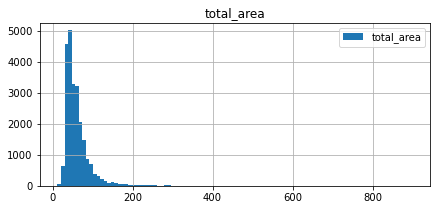

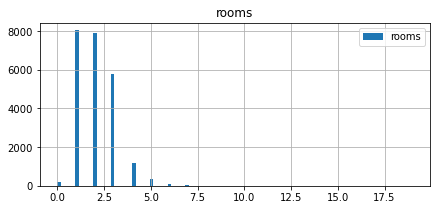

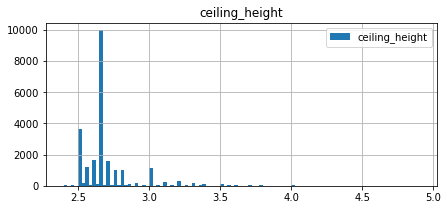

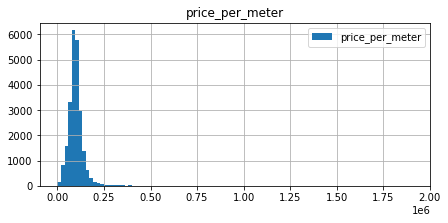

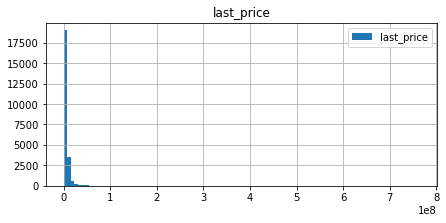

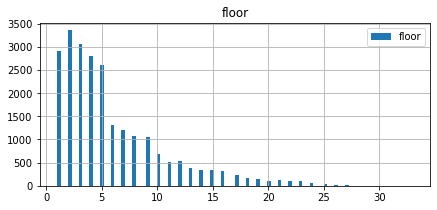

In [39]:
features = ['total_area', 'rooms', 'ceiling_height', 'price_per_meter', 'last_price', 'floor']
for feature in features:
    data.hist(feature, bins=100, figsize = (7,3), grid=True, legend=True)
    plt.show()

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
<br> 1. Графики сторим с помощью Seaborn (это надстройка над matplotlib).
<br> 2. Красиво оформляем. Названия, подписи и т.д.
<br> 3. На одном графике одновременно сторим гистограммы и кривую плотности распределения вероятностей. Рядом "ящик с усами".
<br> 4. Если на графике "длинный хвост" строим уточняющий, определив лимиты по "ящику с усами".
</div>

С помощью гистограмм можно увидеть, что наиболее часто появляются объявления о продаже квартир общей площадью до 90 кв.м., 1-2-х комнатные (реже трехкомнатные), с высотой потолка от 2,5 до 2,7 м., стоимостью за один метр квадратный до 150 тыс., расположенные на 1-5 этажах.  Стоимость квартиры нерепрезентативна - построим гистрограмму с другими параметрами.

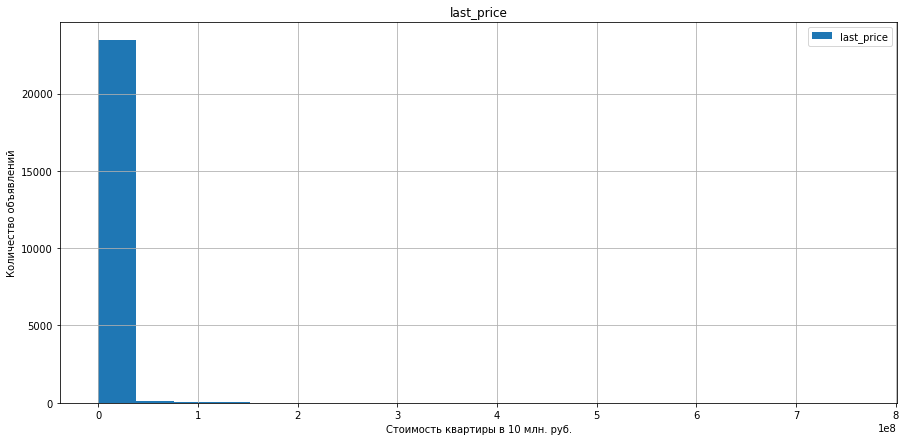

In [40]:
data.hist('last_price', bins=20, figsize = (15,7), grid=True, legend=True)
plt.xlabel('Стоимость квартиры в 10 млн. руб.'), plt.ylabel('Количество объявлений')
plt.show()

Наиболее типично объявление со стоимостью работ до 4 млн. рублей

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
График вообще не информативен. Смотри выше комментарий. Плюс есть правила выбора bins. 
</div>

### <a id='researching-days-exposition'><span style="color:black">Исследование времени продажи квартиры</span></a>

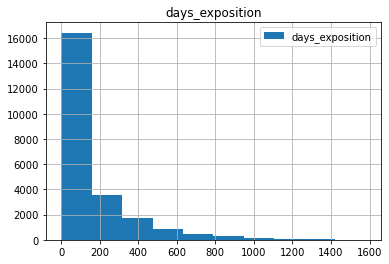

count    23650.000000
mean       169.222748
std        206.550577
min          1.000000
25%         45.000000
50%         95.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [41]:
data.hist(column = 'days_exposition', grid=True, legend=True)
plt.show()
display(data['days_exposition'].describe())

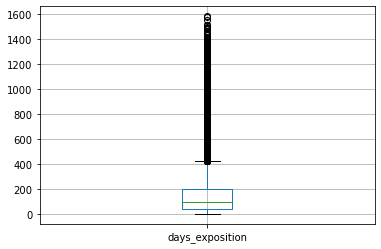

In [42]:
data.boxplot(column = 'days_exposition')
plt.show()

Графики показывают, что наиболее часто квартиры продаются в первые 170 дней. При этом имеется длиный хвост до 1580 дней (более  4 лет). Диаграмма размаха показывает, что все значения после 430 являются выбросами. Описание данных показывает, что разброс данных составляет до 206 дней (скорее всего такие объявления уже теряют свою актуальность и 'висят' только потому, что их никто не снимает).

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Прочитай про P10, P50 и P90. Иногда используются P5, P50 и P95.
</div>

### <a id='processing-rare&knockout-values'><span style="color:black">Обработка необычных значений параметров</span></a>

С помощью графиков и расчетов определим выбросы в значениях основных параметров квартир.

Upper limit = 114.25


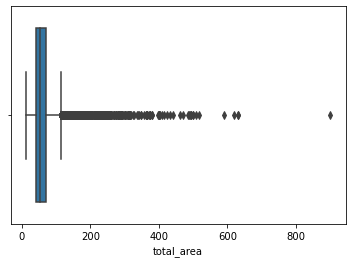

Upper limit = 6.0


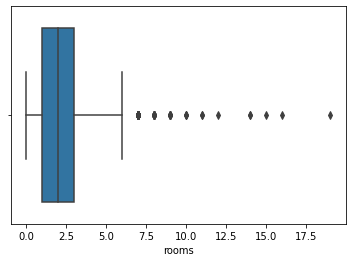

Upper limit = 2.85
Lower limit = 2.45


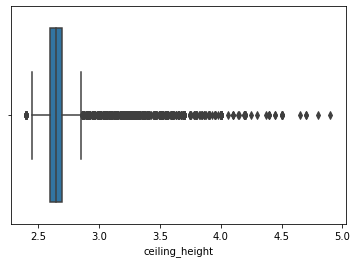

Upper limit = 170762.95
Lower limit = 20126.17


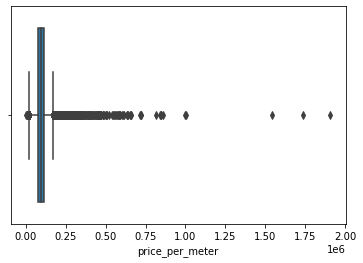

Upper limit = 11897500.0


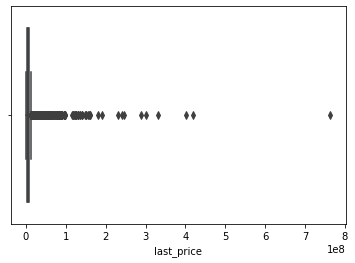

Upper limit = 17.0


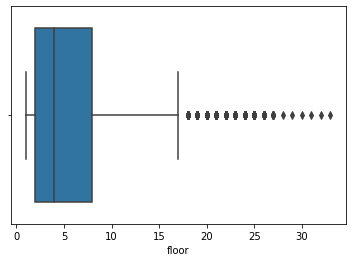

In [43]:
def set_limit(feature):
    Q3 = data[feature].quantile(0.75)
    Q1 = data[feature].quantile(0.25)
    IQR = Q3 - Q1
    upper_limit = (Q3 + 1.5*IQR)
    print(f'Upper limit = {round(upper_limit, 2)}')
    lower_limit = (Q1 - 1.5*IQR)
    if lower_limit > 0:
        print(f'Lower limit = {round(lower_limit, 2)}')
    limit = [round(upper_limit, 2), round(lower_limit, 2)]
    return limit

for feature in features:
    sns.boxplot(data[feature])
    set_limit(feature)
    plt.show()

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
И тут вопрос? Почему раньше не использовал seaborn в предыдущих графиках?
<br> Лучше где-то в начале написать функцию для графика и использовать по всему ноутбуку.
</div>

С помощью диаграмм размаха и произведенных расчетов можно выявить не типичные значения, которые являются выбросами. Такие данные могут соответствовать реальным отклонениям, но могут быть и просто ошибками. Попробуем отбросить не типичные значения и построим новые гистрограммы.

Upper limit = 114.25


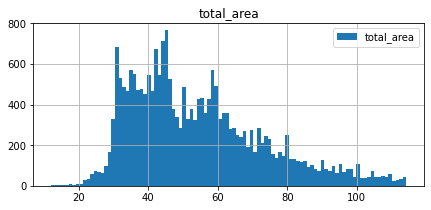

Upper limit = 6.0


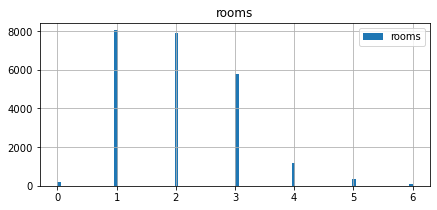

Upper limit = 2.85
Lower limit = 2.45


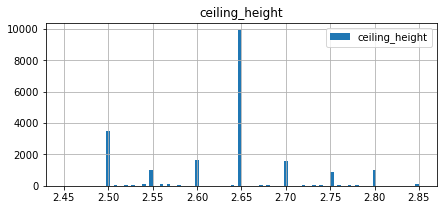

Upper limit = 170762.95
Lower limit = 20126.17


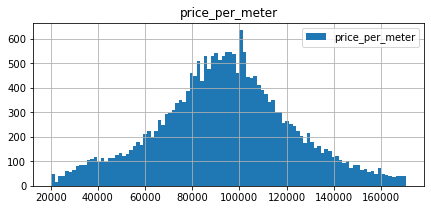

Upper limit = 11897500.0


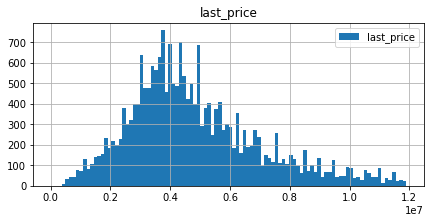

Upper limit = 17.0


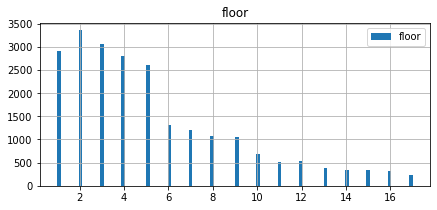

In [44]:
features = ['total_area', 'rooms', 'ceiling_height', 'price_per_meter', 'last_price', 'floor']
for feature in features:
    limit = set_limit(feature)
    clean_data = data[(data[feature] <= limit[0]) & (data[feature] >= limit[1])]
    clean_data.hist(feature, bins=100, figsize = (7,3), grid=True, legend=True)
    plt.show()

После обработки выбрасов гистаграммы прибрели более репрезентативный вид. Обработка редких и выбивающихся значений является помогает выявить и отсечь не типичное поведение данных, что в итоге позволяет сделать выводы, которые могут быть применены в большинстве ситуаций. 

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Тут хорошо.
<br> Можно все сделать компактнее, комментарий выше.
</div>

### <a id='research-factors-affecting-cost'><span style="color:black">Исследование факторов, влияющих на стоимость квартиры</span></a>

Значение коэффициента корреляции Пирсона составил 0.64, что соответствует заметной связи между last_price и total_area.


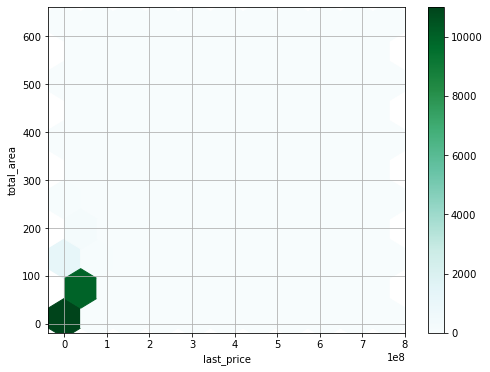

Значение коэффициента корреляции Пирсона составил 0.5, что соответствует заметной связи между last_price и kitchen_area.


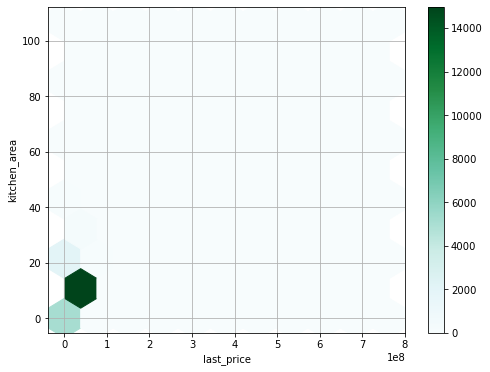

Значение коэффициента корреляции Пирсона составил 0.58, что соответствует заметной связи между last_price и living_area.


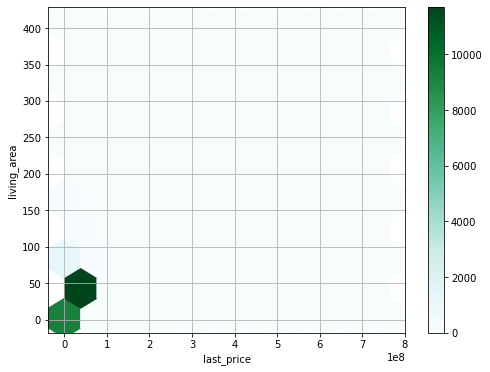

Значение коэффициента корреляции Пирсона составил 0.36, что соответствует умереной связи между last_price и rooms.


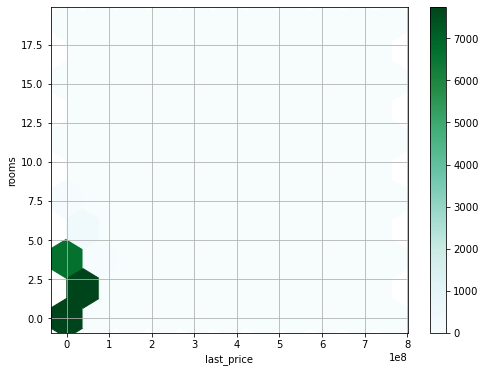

Значение коэффициента корреляции Пирсона составил 0.29, что соответствует слабой связи между last_price и ceiling_height.


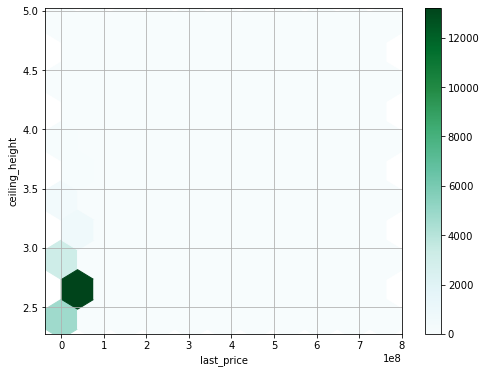

Значение коэффициента корреляции Пирсона составил 0.03, что соответствует слабой связи между last_price и floor.


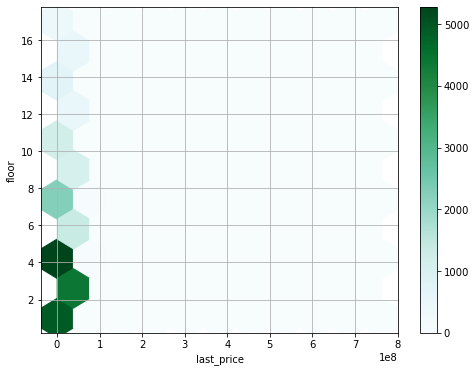

Значение коэффициента корреляции Пирсона составил -0.27, что соответствует слабой связи между last_price и cityCenters_nearest.


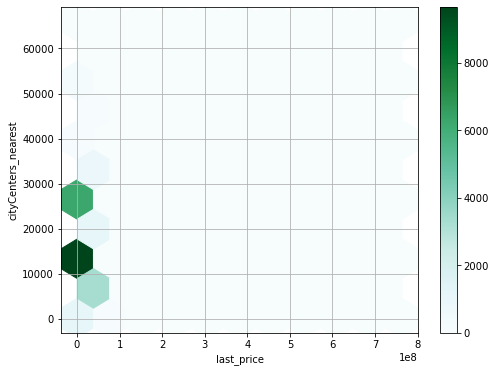

In [45]:
def set_correlation_coefficient(data, col):
    if (round(data['last_price'].corr(data[col]))) < 0:
        cor = 'отрицательной '
    else: cor = ''
        
    if abs(data['last_price'].corr(data[col])) < 0.3:
        cor += 'слабой'
    elif abs(data['last_price'].corr(data[col])) < 0.5:
        cor += 'умереной'
    elif abs(data['last_price'].corr(data[col])) < 0.7:
        cor += 'заметной'
    elif abs(data['last_price'].corr(data[col])) < 0.9:
        cor += 'высокой'
    elif abs(clean_data['last_price'].corr(data[col])) < 1:
        cor += 'весьма высокой'
    elif abs(data['last_price'].corr(data[col])) == 1:
        cor += 'абсолютной'
    correlation = f'Значение коэффициента корреляции Пирсона составил {round(data["last_price"].corr(data[col]), 2)}, что соответствует {cor} связи между last_price и {col}.'
    print(correlation)

features = ['total_area', 'kitchen_area', 'living_area', 'rooms', 'ceiling_height', 'floor', 'cityCenters_nearest']
for feature in features:
    clean_data.plot(kind='hexbin', x = 'last_price', y = feature, gridsize=10, figsize=(8, 6), sharex=False, grid=True)
    set_correlation_coefficient(clean_data, feature)
    plt.show()

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Используй sns.pairplot.
</div>

1. Зависимость цены от площади.
Как и ожидалось наибольшая зависимость стоимости квартиры наблюдается от площади, заметная корреляция имеется по всем трем показателям: общая площадь, жилая площадь, площадь кухни. Наибольший коэффициент корреляции составил 0.64, показывающий связь между общей площадью и ценой.

2. Зависимость цены от числа комнат.
Зависимости нет, коэффициент корреляции Пирсона равен 0.36. При этом на диаграмме наблюдается следующая картина: при увеличении количества комнат от 3 до 5 уменьшается стоимость квартиры. Возможно это связано с общей площадью, т.е. площадь может быть не большой, а количество маленьких комнат больше, чем например в квартире-студии большей общей площади.

3. Зависимость цены от этажа.
Зависимости не наблюдается, коэффициент корреляции Пирсона равен 0.03.

4. Зависимость цены от высоты потолка.
Зависимости не наблюдается, коэффициент корреляции Пирсона равен 0.29.

5. Зависимость цены от удаленности от центра.
Коэффициент корреляции Пирсона равен -0.27. Коэффициент отрицательный, что логично, т.к. при большем расстоянии от центра количество дорогих квартир падает.

Рассмотрим подробнее зависимость стоимости квартиры от ее расположения (этажности).

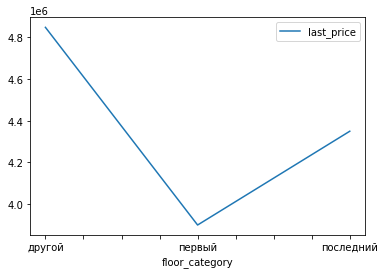

In [46]:
report = data.groupby('floor_category').agg({'last_price' : 'median'});
report.plot(kind='line');

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Больше на галочку похоже). Тут больше гистограмма подходит.
</div>

На графике явно видно, что цена на первых и последних этажах ниже, чем на средних этажах. С развитием коммерческой недвижимости на первых этажах можно ожидать, что такая зависимость может изменится.

Рассмотрим есть зависимость от времени подачи размещения объявления.

Значение коэффициента корреляции Пирсона составил 0.0, что соответствует слабой связи между last_price и weekday_exposition.


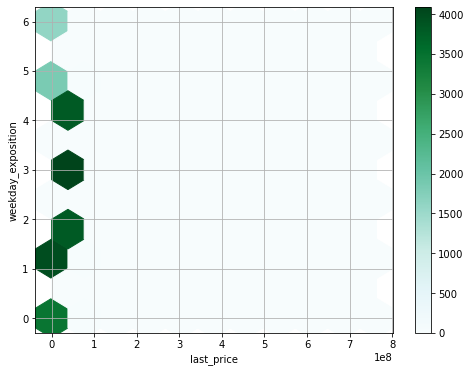

Значение коэффициента корреляции Пирсона составил 0.0, что соответствует слабой связи между last_price и month_exposition.


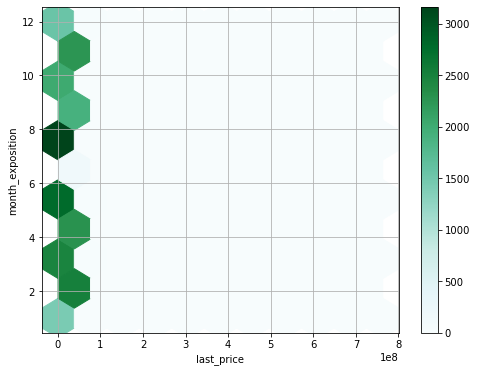

Значение коэффициента корреляции Пирсона составил -0.05, что соответствует слабой связи между last_price и year_exposition.


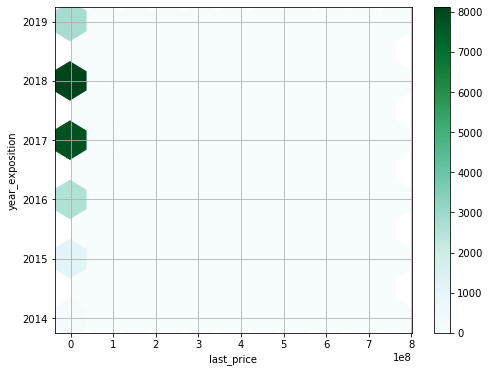

In [47]:
features = ['weekday_exposition', 'month_exposition', 'year_exposition']
for feature in features:
    clean_data.plot(kind='hexbin', x = 'last_price', y = feature, gridsize=10, figsize=(8, 6), sharex=False, grid=True)
    set_correlation_coefficient(clean_data, feature)
    plt.show()

Диаграмы и расчет коэффициента корреляции показывают, что зависимости между временем подачи объявления и стоимость квартиры нет.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Используй sns.pairplot  как и выше будет информативнее.
</div>

###  <a id='research-exposition-location'><span style="color:black">Исследование 10 населённых пунктов с наибольшим числом объявлений</span></a> 

                 first_day_exposition  last_price
locality_name                                    
Санкт-Петербург                 15093   5500000.0
Пушкин                            369   5180000.0
Парголово                         238   4145000.0
Шушары                            399   3990000.0
Кудрово                           413   3900000.0
Колпино                           336   3600000.0
Всеволожск                        397   3450000.0
Мурино                            504   3400000.0
Гатчина                           307   3100000.0
Выборг                            237   2897000.0


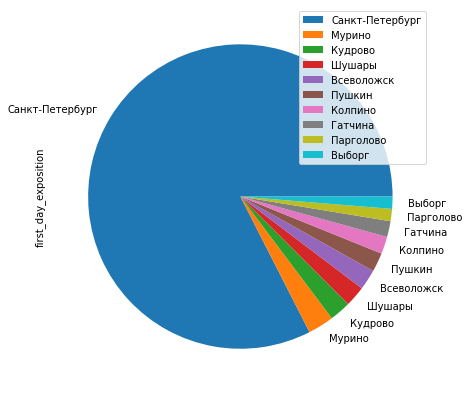

In [48]:
publication_by_location = (
    clean_data.groupby('locality_name')
    .agg({'first_day_exposition': 'count', 'last_price': 'median'})
    .sort_values('first_day_exposition', ascending=False)
    .head(10)
)


print(publication_by_location.sort_values('last_price', ascending=False))
publication_by_location.plot(y='first_day_exposition', kind='pie', figsize=(7, 7))
plt.show()

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Всегда сортируй. Гистограмма с подписанными значениями компактней.
</div>

Анализ данных 10 населённых пунктов с наибольшим числом объявлений показывает, что количество объявление в Санкт-Петербурге более чем в 3 раза превышает общее количество объявлений в 9 пригородах. При этом стоимость квартиры в Пушкино не сильно уступает стоимости квартиры в Санкт-Петербурге. Наименьшая стоимость квартир из данной выборки наблюдается в Выборге.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Не нашел ответа на вопрос "Выделите населённые пункты с самой высокой и низкой стоимостью жилья" в задании. 
</div>

### <a id='research-centre-or-no-centre'><span style="color:black">Исследование характеристик типичных квартир в центре и вне центра</span></a> 

Для исследования характеристик типичных квартир в центре и вне центра определим какое расстояния будет разделять эти категории. Так как разбежка в расстоянии до центра довольна велика возьмем за основу первый квартиль.

In [49]:
flats_center = clean_data[clean_data['cityCenters_nearest'] <= clean_data['cityCenters_nearest'].quantile(0.25)]
display(flats_center.describe())

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exposition,month_exposition,year_exposition,ratio_living_total_area,ratio_kitchen_total_area
count,5.687000e+03,5687.000000,5687.000000,5687.000000,5687.000000,5687.000000,5687.000000,5687.000000,5687.000000,5676.000000,5687.000000,5687.000000,3612.000000,5687.000000,3591.000000,5687.000000,5.687000e+03,5687.000000,5687.000000,5687.000000,5687.000000,5687.000000
mean,1.195239e+07,80.690139,2.550202,2.850536,8.338140,47.381345,4.618252,13.037834,0.359240,26529.784531,6384.097767,0.939335,502.423588,1.117988,475.253968,204.304203,1.338174e+05,2.534904,6.359065,2017.238439,0.577980,0.175026
std,1.976582e+07,52.820262,1.352387,0.324442,4.949175,33.789388,3.230129,8.703270,0.683079,7835.539245,2754.899949,0.893765,402.546255,1.093407,267.064639,245.007166,7.796615e+04,1.750676,3.447072,1.117812,0.105687,0.076596
min,1.600000e+06,12.000000,0.000000,2.400000,2.000000,2.000000,1.000000,0.000000,0.000000,9258.000000,181.000000,0.000000,9.000000,0.000000,22.000000,2.000000,1.534527e+04,0.000000,1.000000,2014.000000,0.021583,0.000000
25%,5.300000e+06,47.000000,2.000000,2.650000,5.000000,27.400000,2.000000,8.000000,0.000000,21710.500000,4327.000000,0.000000,285.000000,0.000000,248.500000,60.000000,9.712912e+04,1.000000,3.000000,2017.000000,0.521132,0.124701
50%,7.730000e+06,68.000000,2.000000,2.680000,6.000000,39.000000,4.000000,10.600000,0.000000,25277.500000,6031.000000,1.000000,441.000000,1.000000,454.000000,95.000000,1.163522e+05,3.000000,6.000000,2017.000000,0.576737,0.162791
75%,1.200000e+07,95.700000,3.000000,3.000000,10.000000,56.650000,6.000000,15.000000,0.000000,31460.000000,8875.500000,1.000000,602.000000,2.000000,674.500000,252.000000,1.445783e+05,4.000000,9.000000,2018.000000,0.650602,0.203061
max,7.630000e+08,631.200000,19.000000,4.900000,28.000000,409.000000,17.000000,107.000000,5.000000,44831.000000,10842.000000,3.000000,3190.000000,3.000000,1313.000000,1572.000000,1.907500e+06,6.000000,12.000000,2019.000000,0.983447,0.636986


In [50]:
typical_center = flats_center[(flats_center['total_area'] >= 47) & (flats_center['total_area'] <= 95.7)
                             & (flats_center['rooms'] >= 2) & (flats_center['rooms'] <= 3)
                             & (flats_center['floor'] >= 2) & (flats_center['floor'] <= 6)]

In [51]:
no_center = clean_data[clean_data['cityCenters_nearest'] >= clean_data['cityCenters_nearest'].quantile(0.25)]
display(no_center.describe())

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exposition,month_exposition,year_exposition,ratio_living_total_area,ratio_kitchen_total_area
count,1.705000e+04,17050.000000,17050.000000,17050.000000,17050.000000,17050.000000,17050.000000,17050.000000,17050.000000,11690.000000,17050.000000,11702.000000,4283.000000,11702.000000,5175.000000,17050.000000,17050.000000,17050.000000,17050.000000,17050.000000,17050.000000,17050.000000
mean,4.715317e+06,53.617804,1.929795,2.644951,10.740762,30.562073,5.505806,9.496255,0.580938,29767.712660,21778.697126,0.474107,476.987625,0.613399,547.669565,157.796774,87405.329197,2.576070,6.409032,2017.415367,0.564242,0.185849
std,3.181777e+06,23.618257,0.921424,0.131493,6.361268,14.736286,4.039920,4.507903,0.799906,14135.869572,8880.519518,0.714989,280.766528,0.810843,281.287437,190.540501,29863.604020,1.801614,3.506171,1.008334,0.098200,0.068117
min,4.300000e+05,13.000000,0.000000,2.400000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,10842.000000,0.000000,1.000000,0.000000,13.000000,1.000000,7962.960000,0.000000,1.000000,2014.000000,0.069588,0.000000
25%,3.100000e+06,38.500000,1.000000,2.560000,5.000000,18.200000,2.000000,6.900000,0.000000,17101.000000,13904.000000,0.000000,289.000000,0.000000,332.500000,45.000000,69444.440000,1.000000,3.000000,2017.000000,0.500000,0.139375
50%,4.120000e+06,48.100000,2.000000,2.650000,9.000000,29.000000,4.000000,8.700000,0.000000,28421.500000,17501.000000,0.000000,463.000000,0.000000,541.000000,95.000000,88372.090000,3.000000,6.000000,2017.000000,0.568161,0.170000
75%,5.500000e+06,62.400000,3.000000,2.650000,16.000000,39.000000,8.000000,11.000000,1.000000,40836.500000,30371.000000,1.000000,615.500000,1.000000,758.000000,184.750000,104878.050000,4.000000,10.000000,2018.000000,0.627133,0.225806
max,1.300000e+08,470.300000,10.000000,4.500000,60.000000,279.600000,17.000000,71.770000,5.000000,84869.000000,65968.000000,3.000000,2131.000000,3.000000,1344.000000,1580.000000,640422.350000,6.000000,12.000000,2019.000000,1.000000,0.787879


In [52]:
typical_no_center = no_center[(no_center['total_area'] >= 38.3) & (no_center['total_area'] <= 62.7)
                             & (no_center['rooms'] >= 1) & (no_center['rooms'] <= 3)
                             & (no_center['floor'] >= 2) & (no_center['floor'] <= 9)]

In [53]:
features = ['total_area', 'rooms', 'ceiling_height', 'floor', 'cityCenters_nearest']
print('Корреляцию основных факторов с ценой в центре')
for feature in features:
    set_correlation_coefficient(typical_center, feature)

Корреляцию основных факторов с ценой в центре
Значение коэффициента корреляции Пирсона составил 0.52, что соответствует заметной связи между last_price и total_area.
Значение коэффициента корреляции Пирсона составил -0.0, что соответствует слабой связи между last_price и rooms.
Значение коэффициента корреляции Пирсона составил 0.18, что соответствует слабой связи между last_price и ceiling_height.
Значение коэффициента корреляции Пирсона составил 0.08, что соответствует слабой связи между last_price и floor.
Значение коэффициента корреляции Пирсона составил -0.22, что соответствует слабой связи между last_price и cityCenters_nearest.


In [54]:
features = ['total_area', 'rooms', 'ceiling_height', 'floor', 'cityCenters_nearest']
print('Корреляцию основных факторов с ценой вне центра')
for feature in features:
    set_correlation_coefficient(typical_no_center, feature)

Корреляцию основных факторов с ценой вне центра
Значение коэффициента корреляции Пирсона составил 0.33, что соответствует умереной связи между last_price и total_area.
Значение коэффициента корреляции Пирсона составил 0.05, что соответствует слабой связи между last_price и rooms.
Значение коэффициента корреляции Пирсона составил 0.11, что соответствует слабой связи между last_price и ceiling_height.
Значение коэффициента корреляции Пирсона составил 0.23, что соответствует слабой связи между last_price и floor.
Значение коэффициента корреляции Пирсона составил -0.56, что соответствует отрицательной заметной связи между last_price и cityCenters_nearest.


Наблюдается снижение зависимости цены от площади. Если ранее коэффициент корреляции составлял 0.64, показывающий связь между общей площадью и ценой, то согласно выборке в центре такая связь составляет 0.52, а вне центра 0.33. Также наблюдается снижение и по всем остьльным факторам. Единственный коэффицент который увеличился (хоть и со знаком минус) - зависимость между расстоянием от центра и ценой в выборке вне центра, что является логичным.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Читаем внимательно задание: "Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона."
<br>!!! Почему первый квартиль? Переделываем. 
</div>

### <a id='research-nontypical-flat'><span style="color:black">Исследование характерных параметров для апартаментов, студий и квартир свободной планировки</span></a> 

In [55]:
sampling = clean_data[(clean_data['is_apartment'] == True) | (clean_data['studio'] == True) | (clean_data['open_plan'] == True)]
display(sampling.describe())

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exposition,month_exposition,year_exposition,ratio_living_total_area,ratio_kitchen_total_area
count,2.450000e+02,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,157.000000,245.000000,159.000000,49.000000,159.000000,99.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,5.525750e+06,41.670653,0.542857,2.767796,13.942857,26.557020,6.542857,4.805673,1.008163,27343.477707,19497.510204,0.503145,418.897959,0.955975,528.080808,129.538776,116014.406367,2.612245,6.893878,2017.404082,0.662735,0.081836
std,9.786651e+06,46.667715,1.091697,0.280037,7.308540,27.698519,4.636279,9.721714,0.914330,12807.558633,10011.712125,0.848485,271.763856,0.976599,268.759648,211.874836,61224.851783,1.681826,3.431556,0.972987,0.118825,0.103411
min,9.457500e+05,15.500000,0.000000,2.500000,2.000000,5.000000,1.000000,0.000000,0.000000,6989.000000,318.000000,0.000000,4.000000,0.000000,22.000000,3.000000,34375.000000,0.000000,1.000000,2014.000000,0.227273,0.000000
25%,2.350000e+06,25.000000,0.000000,2.650000,7.000000,16.700000,3.000000,0.000000,0.000000,18490.000000,12419.000000,0.000000,170.000000,0.000000,323.000000,29.000000,90252.710000,1.000000,4.000000,2017.000000,0.586207,0.000000
50%,3.100000e+06,27.810000,0.000000,2.650000,15.000000,18.620000,6.000000,0.000000,1.000000,24329.000000,17399.000000,0.000000,383.000000,1.000000,552.000000,60.000000,106227.110000,3.000000,7.000000,2017.000000,0.678571,0.000000
75%,4.090000e+06,34.000000,1.000000,2.760000,19.000000,23.600000,10.000000,5.180000,2.000000,35248.000000,30371.000000,1.000000,592.000000,1.000000,774.000000,113.000000,126229.510000,4.000000,10.000000,2018.000000,0.720000,0.170000
max,8.400000e+07,507.000000,7.000000,4.500000,35.000000,301.500000,17.000000,87.200000,2.000000,73391.000000,54490.000000,3.000000,1021.000000,3.000000,1159.000000,1572.000000,600000.000000,6.000000,12.000000,2019.000000,1.000000,0.490163


In [56]:
sampling_common = clean_data[(clean_data['is_apartment'] == False) | (clean_data['studio'] == False) | (clean_data['open_plan'] == False)]
display(sampling_common.describe())

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exposition,month_exposition,year_exposition,ratio_living_total_area,ratio_kitchen_total_area
count,2.273200e+04,22732.000000,22732.000000,22732.000000,22732.000000,22732.000000,22732.000000,22732.000000,22732.000000,17361.000000,22732.000000,17384.000000,7893.000000,17384.000000,8765.000000,22732.000000,2.273200e+04,22732.000000,22732.000000,22732.000000,22732.000000,22732.000000
mean,6.525844e+06,60.391447,2.084990,2.696389,10.140331,34.769834,5.284005,10.382479,0.525515,28707.568112,17929.743973,0.626323,488.556189,0.778590,517.988933,169.441712,9.901453e+04,2.565722,6.396490,2017.371239,0.567666,0.183146
std,1.073060e+07,35.407523,1.080007,0.217316,6.128370,22.394613,3.872776,6.044683,0.778325,12525.266891,10271.324473,0.808066,342.135217,0.943152,277.838534,206.514705,5.092715e+04,1.789120,3.491548,1.039667,0.100306,0.070494
min,4.300000e+05,12.000000,0.000000,2.400000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,7.962960e+03,0.000000,1.000000,2014.000000,0.021583,0.000000
25%,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18591.000000,10842.000000,0.000000,287.000000,0.000000,293.000000,45.000000,7.590092e+04,1.000000,3.000000,2017.000000,0.505882,0.135135
50%,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26612.000000,14925.500000,0.000000,451.000000,1.000000,503.000000,95.000000,9.449735e+04,3.000000,6.000000,2017.000000,0.568200,0.170000
75%,6.750000e+06,69.800000,3.000000,2.700000,14.000000,42.300000,7.000000,11.800000,1.000000,36998.000000,30371.000000,1.000000,610.000000,1.000000,729.000000,199.000000,1.137402e+05,4.000000,10.000000,2018.000000,0.633758,0.220724
max,7.630000e+08,631.200000,19.000000,4.900000,60.000000,409.000000,17.000000,107.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.907500e+06,6.000000,12.000000,2019.000000,1.000000,0.787879


In [57]:
features = ['total_area', 'rooms', 'ceiling_height', 'floor', 'cityCenters_nearest']
print('Корреляцию основных факторов с ценой по квартирам-студиям, апартаментам и квартирам со свободной планировкой')
for feature in features:
    set_correlation_coefficient(sampling, feature)

Корреляцию основных факторов с ценой по квартирам-студиям, апартаментам и квартирам со свободной планировкой
Значение коэффициента корреляции Пирсона составил 0.88, что соответствует высокой связи между last_price и total_area.
Значение коэффициента корреляции Пирсона составил 0.52, что соответствует заметной связи между last_price и rooms.
Значение коэффициента корреляции Пирсона составил 0.49, что соответствует умереной связи между last_price и ceiling_height.
Значение коэффициента корреляции Пирсона составил -0.08, что соответствует слабой связи между last_price и floor.
Значение коэффициента корреляции Пирсона составил -0.36, что соответствует умереной связи между last_price и cityCenters_nearest.


In [58]:
features = ['total_area', 'rooms', 'ceiling_height', 'floor', 'cityCenters_nearest']
print('Корреляцию основных факторов с ценой по обычным квартирам')
for feature in features:
    set_correlation_coefficient(sampling_common, feature)

Корреляцию основных факторов с ценой по обычным квартирам
Значение коэффициента корреляции Пирсона составил 0.64, что соответствует заметной связи между last_price и total_area.
Значение коэффициента корреляции Пирсона составил 0.36, что соответствует умереной связи между last_price и rooms.
Значение коэффициента корреляции Пирсона составил 0.29, что соответствует слабой связи между last_price и ceiling_height.
Значение коэффициента корреляции Пирсона составил 0.03, что соответствует слабой связи между last_price и floor.
Значение коэффициента корреляции Пирсона составил -0.27, что соответствует слабой связи между last_price и cityCenters_nearest.


Анализ показывает, что стоимость квартир-студий, апартаментов и квартир со свободной планировкой имеет высокую связь с общей площадью таких квартир, что связано с тем, что в таких квартир одна комната и поэтому площадь квартиры является чуть ли не основным фактором влияющим на покупку. Наблюдается увеличение зависимости от количества комнат (скорее всего это связано с тем, что в большинстве таких квартир одна комнта). Наблюдается умеренная связь с высотой потолка (возможная причина в том, что в таких помещениях (часто с одной комнатой) высокие потолки позволяю визуально увеличивать простраство, что может особенно цениться в таких квартирах). Увеличилась до умеренной связь с расстоянием до центра (возможно это связано с тем, что спрос на такие квартиры в спальных районах, а не в центре ниже).

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Не нашел ответа на задание:
"Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления)".
<br>!!! Смотри файл description_project_course2_full.
</div>

**Вывод:** Использование диаграмм и описания данных позволила прийти к следующему. 
- Наиболее часто появляются объявления о продаже квартир общей площадью до 90 кв.м., 1-2-х комнатные (реже трехкомнатные), с высотой потолка от 2,5 до 2,7 м., стоимостью за один метр квадратный до 150 тыс., расположенные на 1-5 этажах. Стоимость квартиры нерепрезентативна - построим гистрограмму с другими параметрами.
- Часто квартиры продаются в первые 170 дней.
- Наибольшая зависимость цены от площади.
- Цена на первых и последних этажах ниже, чем на средних этажах. 
- Анализ показывает, что стоимость квартир-студий, апартаментов и квартир со свободной планировкой имеет высокую связь с общей площадью таких квартир, что связано с тем, что в таких квартир одна комната и поэтому площадь квартиры является чуть ли не основным фактором влияющим на покупку. Наблюдается увеличение зависимости от количества комнат (скорее всего это связано с тем, что в большинстве таких квартир одна комнта). Наблюдается умеренная связь с высотой потолка (возможная причина в том, что в таких помещениях (часто с одной комнатой) высокие потолки позволяю визуально увеличивать простраство, что может особенно цениться в таких квартирах). Увеличилась до умеренной связь с расстоянием до центра (возможно это связано с тем, что спрос на такие квартиры в спальных районах, а не в центре ниже).

## <a id='conclusions'><span style="color:black">5. Выводы</span></a> 

1. В ходе выполнения проекта были решены следующие задачи.

 - удален столбец total_images как избыточный, который в анализе данных не мог быть применен. 
 - были заполнены пропущенные значения в столбце ceiling_height. Скорее всего данные не были указанны собственниками при подаче объявления, т.к. посчитали такую информацию не важной. Обычно в таком случае высота потолков имеет стандартный размер (2.5-2.7 м). 
 - floors_total - пропущенные значения были заполнены значениями, указаными в столбце floor, скорее всего не были указаны продавцом при размещении объявления умышленно, чтобы скрыть расположение квартиры на последнем этаже.
 - living_area - пропущенные значения были заменены с помощью соотношения общей площади и площади кухни.
 - is_apartment. Скорее всего такие данные не были предоставлены собственниками как не существенные. Такая информация указывается только если помещение является аппартаментами, поэтому все пропущенные значения были заменены на False.
 - kitchen_area - пропущенные значения были заменены с помощью соотношения общей площади и площади кухни.
 - balcony - скорее всего человек не указал число балконов, так как их нет. Такие пропуски заменили на 0. Также заменили значения больше 2 на 2 при условии, что площадь квартиры < 150 м.кв.
 - locality_name - почистили шум в значениях данных (удалили типы населенных пунктов).
 - произведена замена типа данных в следующих столбцах: last_price c float на int, floors_total, balcony, rooms c float на int - количество может быть только целым значением, floor c float на int - этажность может быть только целым значением, is_apartment, studio и open_plan c object на bool - принимают только два значения True и False.
 - произведен расчет дополнительных данных и их добавление в исходную таблицу.
 - произведенно исследование данных на предмет закономерностей.

2. В ходе анализа данных были установлены следующие зависимости.
    - Зависимость цены от площади. Как и ожидалось наибольшая зависимость стоимости квартиры наблюдается от площади, заметная корреляция имеется по всем трем показателям: общая площадь, жилая площадь, площадь кухни. Наибольший коэффициент корреляции составил 0.64, показывающий связь между общей площадью и ценой.
    - При выборке типовых факторов квартир в центре и вне центра наблюдается снижение зависимости цены от площади. Согласно выборке в центре такая связь составляет 0.52, а вне центра 0.33. Также наблюдается снижение и по всем остьльным факторам. Единственный коэффицент который увеличился (хоть и со знаком минус) - зависимость между расстоянием от центра и ценой в выборке вне центра, что является логичным.
    - На графике явно видно, что цена на первых и последних этажах ниже, чем на средних этажах. С развитием коммерческой недвижимости на первых этажах можно ожидать, что такая зависимость может изменится.
    - Анализ показывает, что стоимость квартир-студий, апартаментов и квартир со свободной планировкой имеет высокую связь с общей площадью таких квартир, что связано с тем, что в таких квартир одна комната и поэтому площадь квартиры является чуть ли не основным фактором влияющим на покупку. Наблюдается увеличение зависимости от количества комнат (скорее всего это связано с тем, что в большинстве таких квартир одна комнта). Наблюдается умеренная связь с высотой потолка (возможная причина в том, что в таких помещениях (часто с одной комнатой) высокие потолки позволяю визуально увеличивать простраство, что может особенно цениться в таких квартирах). Увеличилась до умеренной связь с расстоянием до центра (возможно это связано с тем, что спрос на такие квартиры в спальных районах, а не в центре ниже).
    - Анализ данных 10 населённых пунктов с наибольшим числом объявлений показывает, что количество объявление в Санкт-Петербурге более чем в 3 раза превышает общее количество объявлений в 9 пригородах. При этом стоимость квартиры в Пушкино не сильно уступает стоимости квартиры в Санкт-Петербурге.
    - Зависимость стоимости квартиры от времени подачи объявления в ходе исследования установлена не была.